In [268]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.titlesize']=8
mpl.rcParams['axes.labelsize']=8
mpl.rcParams['xtick.labelsize']=8
mpl.rcParams['ytick.labelsize']=8


In [269]:
INVALID_VALUE = 255
LATE_VALUE=256
VALID_VALUES=[-1, 0 , 1]
OUTPUT_FOLDER = "Outputs"

RawCorrect_folder=os.path.join(OUTPUT_FOLDER, "RawCorrect")
RawCorrectBlock_folder=os.path.join(OUTPUT_FOLDER, "RawCorrectBlock")
CorrectPercentage_folder=os.path.join(OUTPUT_FOLDER, "CorrectPercentage")
CorrectPercentageBlock_folder=os.path.join(OUTPUT_FOLDER, "CorrectPercentageBlock")
ZeroSeeing_folder=os.path.join(OUTPUT_FOLDER, "ZeroSeeing")
speed_vs_trial_folder=os.path.join(OUTPUT_FOLDER, "SpeedVsTrial") 
left_vs_right_folder=os.path.join(OUTPUT_FOLDER, "LeftVsRight")

SUBJECT_ID_FILE = "LatestSubjectID.txt"
ON_CENTER_TRAIN_PATH = "train_on_cen"
ON_CENTER_TEST_PATH = "test_on_cen"
OFF_CENTER_TRAIN_PATH = "train_off_cen"
OFF_CENTER_TEST_PATH = "test_off_cen"

In [270]:
subject_list=[]
subject_file_path = os.path.join(OUTPUT_FOLDER, SUBJECT_ID_FILE)
subject_file_lines = open(subject_file_path, "r", encoding="utf-8").readlines()

subject_IDs = [int(line.split(" ")[0]) for line in subject_file_lines]
subject_names = [line.split(" ")[1] for line in subject_file_lines]
subject_status = [int(line.split(" ")[2]) for line in subject_file_lines]


In [271]:
class velocity_value():
    def __init__(self,velocity, trial, correct=0,add_percentage=False):
        self.velocity=velocity
        self.trials=[]
        self.n_correct=0
        self.n_incorrect=0
        self.n_valid=0
        self.n_invalid=0
        self.late_no_response=0
        self.n_total=0
        if add_percentage !=False:
            self.add_percentage_correct(trial,correct,add_percentage)
        else:
            self.add_trial(trial, correct)

       
    def add_trial(self,trial,correct=0):
        self.trials.append(trial)
        if correct==1:
            self.n_correct+=1
            self.n_valid+=1
        elif correct==-1:
            self.n_incorrect+=1
            self.n_valid+=1
        elif correct==INVALID_VALUE:
            self.n_invalid+=1
        elif correct==LATE_VALUE:
            self.late_no_response+=1
        self.n_total+=1
    
    def add_percentage_correct(self,trial,num=0,total_trials=3):
        self.trials.append(trial)
        self.n_correct+=num
        self.n_valid+=total_trials

    def get_percent_correct(self):
        return self.n_correct/(self.n_valid)
    
    def get_percent_incorrect(self):
        return self.n_incorrect/(self.n_valid)
     
    
    def get_percent_late(self):
        return self.late_no_response/(self.n_total-self.n_invalid)
    
    def get_percent_invalid(self):
        return self.n_invalid/self.n_total       

class sub_experiment():
    
    def __init__(self, name, velocities, correct_answers, subject_responses, performance, converged):
        self.name=name
        self.velocities_2D = velocities
        self.speed_per_block=np.max(np.abs(self.velocities_2D),axis=-1)
        self.correct_answers2D = correct_answers
        self.subject_responses_2D = subject_responses
        self.velocities=velocities.flatten()
        self.correct_answers=correct_answers.flatten()
        self.subject_responses=subject_responses.flatten()
        self.performance = performance
        self.converged = converged
        self.vdict={}
        self.populate_vdict()
        self.speedDict={}
        self.populate_speed_dict()
        self.block_v_dict={}
        self.block_populate_vdict()
        self.convergent_value=self.get_convergent_value()

    def populate_vdict(self):
        for i in range(len(self.velocities)):
             if self.velocities[i] not in self.vdict:                
                self.vdict[self.velocities[i]]=velocity_value(self.velocities[i],i,correct=self.get_correctness(i))
             else:
                self.vdict[self.velocities[i]].add_trial(i,correct=self.get_correctness(i))
        self.cleanup(self.vdict)
    def block_populate_vdict(self):
        for i in range(len(self.velocities_2D)):
            count=0
            v=0
            for j in range(len(self.velocities_2D[i])):
                
                if self.velocities_2D[i][j]!=0:
                    count+=1
                    v=abs(self.velocities_2D[i][j])
            
            if v not in self.block_v_dict:
                self.block_v_dict[v]=velocity_value(v,i,correct=self.performance[i],add_percentage=count)
            else:
                self.block_v_dict[v].add_percentage_correct(i,self.performance[i],count)
            

            
        self.cleanup(self.block_v_dict)

    def populate_speed_dict(self):
        for i in range(len(self.velocities)):
            speed=abs(self.velocities[i])
            if speed not in self.speedDict:              
                self.speedDict[speed]=velocity_value(speed,i,correct=self.get_correctness(i))
            else:
                self.speedDict[speed].add_trial(i,correct=self.get_correctness(i))
        self.cleanup(self.speedDict)
    
    def get_convergent_value(self):
        # find the velocity value to which the subject converged using self.speedperblock
        # return the velocity value
        return (np.average(self.speed_per_block[-3:])+np.min(self.speed_per_block))/2
    
    def plot_speed_vs_trial(self,axis):
        axis.plot(self.speed_per_block)
        axis.set_title(self.name)
        axis.set_xlabel("Trial")
        axis.set_ylabel("Speed")
        axis.axhline(y=self.convergent_value,color='r', linestyle='-')
 

    @staticmethod
    def cleanup(v_value_dict):
        list=[]
        for v,v_obj in v_value_dict.items():
            if v_obj.n_valid==0:
                list.append(v)
        for v in list:
            del v_value_dict[v]
        return v_value_dict
        
   
    def get_correctness(self,i):
        if self.subject_responses[i]==INVALID_VALUE:
            return INVALID_VALUE
        elif self.subject_responses[i]==LATE_VALUE:
            return LATE_VALUE
        elif self.subject_responses[i]==self.correct_answers[i]:
            return 1
        else:
            return -1

    def plot_correctness_raw (self,axis):

        for s,s_obj in self.speedDict.items():
            if s!=0:
                axis.plot(s,s_obj.get_percent_correct(),'.',color='orange')
        axis.set_xlabel("Speed")
        axis.set_ylabel("Percent Correct")
    
    def plot_correctness_raw_block (self,axis):            
            for s,s_obj in self.block_v_dict.items():
                if s!=0:
                    axis.plot(s,s_obj.get_percent_correct(),'.',color='orange')
            axis.set_xlabel("Speed")
            axis.set_ylabel("Percent Correct")
    
    def plot_correctness_bar(self,axis,n_bins=5):
        min_speed,max_speed=self.get_min_max_speed(self.speedDict)
        bins = np.linspace(min_speed, max_speed, n_bins+1)
        bin_centers=(bins[1:]+bins[:-1])/2
        bin_width=bins[1]-bins[0]
        bin_correctness=np.zeros(n_bins)     
        counts=np.zeros(n_bins) 
        for s,s_obj in self.speedDict.items():
            if s==0:
                continue
            for i in range(len(bins)-1):
                if s>=bins[i] and s<bins[i+1]:
                    bin_correctness[i]+=s_obj.get_percent_correct()*s_obj.n_valid
                    counts[i]+=s_obj.n_valid

        bin_correctness=bin_correctness/counts
        axis.bar(bin_centers,bin_correctness,bin_width)
        axis.set_xlabel("Speed")
        axis.set_ylabel("Percent Correct")
        return bins,bin_centers,bin_correctness

    def plot_correctness_bar_block(self,axis,n_bins=5):
        min_speed,max_speed=self.get_min_max_speed(self.block_v_dict)
        bins = np.linspace(min_speed, max_speed, n_bins+1)
        bin_centers=(bins[1:]+bins[:-1])/2
        bin_width=bins[1]-bins[0]
        bin_correctness=np.zeros(n_bins)     
        counts=np.zeros(n_bins) 
        for s,s_obj in self.block_v_dict.items():
            if s==0:
                continue
            for i in range(len(bins)-1):
                if s>=bins[i] and s<bins[i+1]:
                    bin_correctness[i]+=s_obj.get_percent_correct()
                    counts[i]+=1

        bin_correctness=bin_correctness/counts
        axis.bar(bin_centers,bin_correctness,bin_width)
        axis.set_xlabel("Speed")
        axis.set_ylabel("Percent Correct")
        return bins,bin_centers,bin_correctness
        
    def get_min_max_speed(self,speed_dict):
        min_speed=min(speed_dict.keys()-[0])
        max_speed=max(speed_dict.keys())
        return min_speed,max_speed
    
    def zero_velocity_correct_scatter(self,axis,ifhist=False):
        zero_list=[]
        zero_v_list=[] 
  
        for i,speeds in enumerate(self.velocities_2D):
            zpos=None
            speed_val=None
            for j,speed in enumerate(speeds):
                if speed==0:
                    zpos=j
                if speed!=0:
                    speed_val=abs(speed)
            if zpos is not None:
        
                zero_list.append(self.correct_answers2D[i][zpos]==self.subject_responses_2D[i][zpos])
                zero_v_list.append(speed_val)
        if ifhist:
            order=np.argsort(zero_v_list)
            axis.hist(zero_list[order])
        else:
            axis.scatter(zero_v_list,zero_list)
        return zero_v_list,zero_list
    
    def left_vs_right_non_moving_percentage(self,axis):
        left_list=self.velocities<0
        right_list=self.velocities>0
        zero_list=self.velocities==0
        left_correct=self.correct_answers[left_list]==self.subject_responses[left_list]
        right_correct=self.correct_answers[right_list]==self.subject_responses[right_list]
        zero_correct=self.correct_answers[zero_list]==self.subject_responses[zero_list]
        yvals=[np.sum(left_correct)/np.sum(left_list),np.sum(right_correct)/np.sum(right_list),np.sum(zero_correct)/np.sum(zero_list)]
        axis.bar([0,1,2],yvals)
        axis.legend(["Leftward, Rightward,Non-Moving"],fontsize=5,loc='upper left')
        axis.set_ylabel("Percent Correct")
        axis.set_ylim([0,1])
        return yvals
  




In [272]:
from turtle import color


class subject():
    def __init__(self, ID,Name,experiment_success):
        self.ID = ID
        self.Name = Name
        off_center_train_path = os.path.join(OUTPUT_FOLDER, OFF_CENTER_TRAIN_PATH, "subject_" + str(ID) + ".npz")
        off_center_test_path = os.path.join(OUTPUT_FOLDER, OFF_CENTER_TEST_PATH, "subject_" + str(ID) + ".npz")
        on_center_train_path = os.path.join(OUTPUT_FOLDER, ON_CENTER_TRAIN_PATH, "subject_" + str(ID) + ".npz")
        on_center_test_path = os.path.join(OUTPUT_FOLDER, ON_CENTER_TEST_PATH, "subject_" + str(ID) + ".npz")
        self.off_center_train=self.load_responses(off_center_train_path, "OFF CENTER")
        self.off_center_test=self.load_responses(off_center_test_path, "OFF CENTER")
        self.on_center_train=self.load_responses(on_center_train_path, "ON CENTER")
        self.on_center_test=self.load_responses(on_center_test_path, "ON CENTER")


    @staticmethod
    def load_responses(path,name):
        # data has velocities, correct_responses, actual_responses, trial_performance, converged       

        data = np.load(path, allow_pickle=True)
        return sub_experiment(name,data['velocities'],data['correct_responses'],data['actual_responses'],data['trial_performance'],data['converged'])

    def plot_correctness_raw(self,*, show=False, savepath=None):
        fig,ax=plt.subplots(1,2,figsize=(4,2))
        self.on_center_test.plot_correctness_raw(ax[0])
        self.off_center_test.plot_correctness_raw(ax[1])
        fig.suptitle(" Raw Correctness for " +str( self.ID),fontsize=8)
        fig.tight_layout()
        if savepath is not None:
            plt.savefig(os.path.join(savepath, "raw_corect_"+str(self.ID)+".png"))
        if show:
            plt.show()
        plt.close()
        return ax
    
    def plot_correctness_raw_block(self,*, show=False, savepath=None):
        fig,ax=plt.subplots(1,2,figsize=(4,2))
        self.on_center_test.plot_correctness_raw_block(ax[0])
        self.off_center_test.plot_correctness_raw_block(ax[1])
        fig.suptitle(" Raw Correctness per block for " +str( self.ID),fontsize=8)
        fig.tight_layout()
        if savepath is not None:
            plt.savefig(os.path.join(savepath, "raw_corect_"+str(self.ID)+".png"))
        if show:
            plt.show()
        plt.close()
        return ax
    
    def plot_correctness_bar(self,*, show=False, savepath=None,n_bins=5):
        fig,ax=plt.subplots(1,2,figsize=(4,2))
        self.on_center_test.plot_correctness_bar(ax[0],n_bins=n_bins)
        self.off_center_test.plot_correctness_bar(ax[1],n_bins=n_bins)
        fig.suptitle("Correctness " +str( self.ID),fontsize=8)
        fig.tight_layout()
        if savepath is not None:
            plt.savefig(os.path.join(savepath, "corectpercentage_"+str(self.ID)+".png"))
        if show:
            plt.show()
        plt.close()
        return ax
    
    def plot_correctness_block_bar(self,*, show=False, savepath=None,n_bins=5):
        fig,ax=plt.subplots(1,2,figsize=(4,2))
        self.on_center_test.plot_correctness_bar_block(ax[0],n_bins=n_bins)
        self.off_center_test.plot_correctness_bar_block(ax[1],n_bins=n_bins)
        fig.suptitle(" Per block Correctness " +str( self.ID),fontsize=8)
        fig.tight_layout()
        if savepath is not None:
            plt.savefig(os.path.join(savepath, "corectpercentage_"+str(self.ID)+".png"))
        if show:
            plt.show()
        plt.close()
        return ax
    
    def seeing_zero_scatter(self,*, show=False, savepath=None,ifhist=False):
        fig,ax=plt.subplots(1,2,figsize=(4,2))
        self.on_center_test.zero_velocity_correct_scatter(ax[0],ifhist=ifhist)
        self.off_center_test.zero_velocity_correct_scatter(ax[1],ifhist=ifhist)
        fig.suptitle("Seeing Zero " +str( self.ID),fontsize=8)
        fig.tight_layout()
        if savepath is not None:
            plt.savefig(os.path.join(savepath, "seeing_zero_"+str(self.ID)+".png"))
        if show:
            plt.show()
        plt.close()
        return ax
    
    def plot_speed_vs_trial(self,*, show=False, savepath=None):
        fig,ax=plt.subplots(1,2,figsize=(4,2))
        self.on_center_test.plot_speed_vs_trial(ax[0])
        self.off_center_test.plot_speed_vs_trial(ax[1])
        fig.suptitle("Speed vs Trial " +str( self.ID),fontsize=8)
        fig.tight_layout()
        if savepath is not None:
            plt.savefig(os.path.join(savepath, "speed_vs_trial_"+str(self.ID)+".png"))
        if show:
            plt.show()
        plt.close()
        return ax

    def left_vs_right(self,*, show=False, savepath=None,errors=None):
        fig,ax=plt.subplots(1,2,figsize=(4,2))
        on=self.on_center_test.left_vs_right_non_moving_percentage(ax[0])
        of=self.off_center_test.left_vs_right_non_moving_percentage(ax[1])
        fig.suptitle("Left vs Right " +str( self.ID),fontsize=8)
        if errors is not None:
            ax[0].errorbar([0,1,2],[on[0],on[1],on[2]],yerr=errors[0],color="black")
            ax[1].errorbar([0,1,2],[of[0],of[1],of[2]],yerr=errors[1],color="black")
        ax[0].set_title("On Center")
        ax[1].set_title("Off Center")
        fig.tight_layout()
        if savepath is not None:
            plt.savefig(os.path.join(savepath, "left_vs_right_"+str(self.ID)+".png"))
        if show:
            plt.show()
        plt.close()
        return  on, of


In [273]:

for i in range(len(subject_IDs)):
    if subject_status[i] == 1:
        print("Subject No. " + str(subject_IDs[i]) + " " + subject_names[i] + " has completed the experiment, with exit code " + str(subject_status[i]))
        subject_list.append(subject(subject_IDs[i],subject_names[i],subject_status[i]))
    else:
        print("Subject No. " + str(subject_IDs[i]) + " " + subject_names[i] + " has not completed the experiment, with exit code " + str(subject_status[i]))



Subject No. -1 None has not completed the experiment, with exit code -1
Subject No. 0 Sudhanshu has not completed the experiment, with exit code 2
Subject No. 1 Sudhanva has completed the experiment, with exit code 1
Subject No. 2 Vinayak_Niraj has completed the experiment, with exit code 1
Subject No. 3 vivek has completed the experiment, with exit code 1
Subject No. 4 Anvesh has completed the experiment, with exit code 1
Subject No. 5 dev has completed the experiment, with exit code 1
Subject No. 6 parthdeshpande has completed the experiment, with exit code 1
Subject No. 7 anubhav has completed the experiment, with exit code 1
Subject No. 8 Tanmai has completed the experiment, with exit code 1
Subject No. 9 AdithyaPonnuraj has completed the experiment, with exit code 1
Subject No. 10 atharva has completed the experiment, with exit code 1
Subject No. 11 chiragNL has completed the experiment, with exit code 1


In [274]:
'''for s in subject_list:
    s.plot_correctness_raw(show=False, savepath=RawCorrect_folder)

    s.plot_correctness_bar(show=False, savepath=RawCorrect_folder)

    s.plot_correctness_bar(show=False,savepath=CorrectPercentage_folder,n_bins=5)

    s.plot_correctness_block_bar(show=False,savepath=CorrectPercentageBlock_folder,n_bins=5)

    s.plot_correctness_raw_block(show=False, savepath=RawCorrectBlock_folder)

    s.seeing_zero_scatter(show=False, savepath=ZeroSeeing_folder)

    s.plot_speed_vs_trial(show=False, savepath=speed_vs_trial_folder)'''

'for s in subject_list:\n    s.plot_correctness_raw(show=False, savepath=RawCorrect_folder)\n\n    s.plot_correctness_bar(show=False, savepath=RawCorrect_folder)\n\n    s.plot_correctness_bar(show=False,savepath=CorrectPercentage_folder,n_bins=5)\n\n    s.plot_correctness_block_bar(show=False,savepath=CorrectPercentageBlock_folder,n_bins=5)\n\n    s.plot_correctness_raw_block(show=False, savepath=RawCorrectBlock_folder)\n\n    s.seeing_zero_scatter(show=False, savepath=ZeroSeeing_folder)\n\n    s.plot_speed_vs_trial(show=False, savepath=speed_vs_trial_folder)'

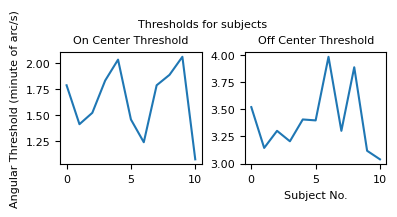

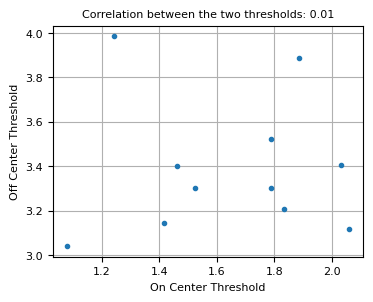

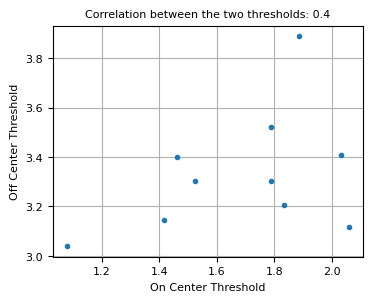

In [275]:



thresholds=np.zeros((len(subject_list),2))
for i,s in enumerate(subject_list):
    thresholds[i][0]=s.on_center_test.convergent_value
    thresholds[i][1]=s.off_center_test.convergent_value

MONITOR_DISTANCE=0.86
DIAGNAL=0.3556
RESOLUTION=np.array([1366,768])
MONITOR_DIMS=DIAGNAL*RESOLUTION/np.sqrt(np.sum(RESOLUTION**2))
PIXEL_SIZE=MONITOR_DIMS/RESOLUTION
cross_position=RESOLUTION/2-50
cross_distance=np.sqrt(np.sum((cross_position*PIXEL_SIZE)**2))
FRAME_RATE=60
Angular_thresholds=np.copy(thresholds)
Angular_thresholds[:,0]*=PIXEL_SIZE[0]*FRAME_RATE/MONITOR_DISTANCE*180/np.pi*60
Angular_thresholds[:,1]*=PIXEL_SIZE[0]*FRAME_RATE/MONITOR_DISTANCE*(1/(1+(cross_distance/MONITOR_DISTANCE)**2))*180/np.pi*60
fig,ax=plt.subplots(1,2,figsize=(4,2))
ax[0].plot(Angular_thresholds[:,0])
ax[0].set_title("On Center Threshold")
ax[0].set_ylabel("Angular Threshold (minute of arc/s)")
ax[1].set_xlabel("Subject No.")
ax[1].plot(Angular_thresholds[:,1])
ax[1].set_title("Off Center Threshold")
fig.suptitle("Thresholds for subjects",fontsize=8)
fig.tight_layout()

plt.figure(figsize=(4,3))
plt.plot(Angular_thresholds[:,0],Angular_thresholds[:,1],".")
plt.xlabel("On Center Threshold")
plt.ylabel("Off Center Threshold")
corr_coef=np.corrcoef(Angular_thresholds[:,0],Angular_thresholds[:,1])[0][1]
plt.title("Correlation between the two thresholds: "+str(round(corr_coef,2)))
plt.grid(which="both")
plt.show()


Angular_thresholds=np.concatenate([Angular_thresholds[:6,:],Angular_thresholds[7:,:]])
plt.figure(figsize=(4,3))
plt.plot(Angular_thresholds[:,0],Angular_thresholds[:,1],".")
plt.xlabel("On Center Threshold")
plt.ylabel("Off Center Threshold")
corr_coef=np.corrcoef(Angular_thresholds[:,0],Angular_thresholds[:,1])[0][1]
plt.title("Correlation between the two thresholds: "+str(round(corr_coef,2)))
plt.grid(which="both")
plt.show()
    

In [298]:
print(np.mean(Angular_thresholds,axis=0),np.std(Angular_thresholds,axis=0))
print(np.mean(thresholds,axis=0),np.std(thresholds,axis=0))
left_right=np.zeros((len(subject_list),2,3))
for i,s in enumerate(subject_list):
    temp=np.array(s.left_vs_right(show=False, savepath=left_vs_right_folder))
    
    left_right[i][0]=np.array(temp[0])
    
    left_right[i][1]=np.array(temp[1])
left_right_errors=np.std(left_right,axis=0)



[1.68624954 3.33256599] [0.29315317 0.23242751]
[0.03024242 0.06454545] [0.00564495 0.00552501]


In [277]:
# we combine all the response on center into one sub experiment object
import copy

combined_subjects_on_center=copy.deepcopy(subject_list[0].on_center_test)
combined_subjects_on_center.name="combined"
combined_subjects_on_center.velocities_2D=np.concatenate([s.on_center_test.velocities_2D for s in subject_list],axis=0)
combined_subjects_on_center.correct_answers2D=np.concatenate([s.on_center_test.correct_answers2D for s in subject_list],axis=0)
combined_subjects_on_center.subject_responses_2D=np.concatenate([s.on_center_test.subject_responses_2D for s in subject_list],axis=0)
combined_subjects_on_center.velocities=np.concatenate([s.on_center_test.velocities for s in subject_list])
combined_subjects_on_center.correct_answers=np.concatenate([s.on_center_test.correct_answers for s in subject_list])
combined_subjects_on_center.subject_responses=np.concatenate([s.on_center_test.subject_responses for s in subject_list])
combined_subjects_on_center.performance=np.concatenate([s.on_center_test.performance for s in subject_list])

combined_subjects_on_center.vdict={}
combined_subjects_on_center.populate_vdict()
combined_subjects_on_center.speedDict={}
combined_subjects_on_center.populate_speed_dict()
combined_subjects_on_center.block_v_dict={}
combined_subjects_on_center.block_populate_vdict()


combined_subjects_off_center=copy.deepcopy(subject_list[0].off_center_test)
combined_subjects_off_center.name="combined"
combined_subjects_off_center.velocities_2D=np.concatenate([s.off_center_test.velocities_2D for s in subject_list],axis=0)  
combined_subjects_off_center.correct_answers2D=np.concatenate([s.off_center_test.correct_answers2D for s in subject_list],axis=0)
combined_subjects_off_center.subject_responses_2D=np.concatenate([s.off_center_test.subject_responses_2D for s in subject_list],axis=0)
combined_subjects_off_center.velocities=np.concatenate([s.off_center_test.velocities for s in subject_list])
combined_subjects_off_center.correct_answers=np.concatenate([s.off_center_test.correct_answers for s in subject_list])
combined_subjects_off_center.subject_responses=np.concatenate([s.off_center_test.subject_responses for s in subject_list])
combined_subjects_off_center.performance=np.concatenate([s.off_center_test.performance for s in subject_list])


combined_subjects_off_center.vdict={}
combined_subjects_off_center.populate_vdict()
combined_subjects_off_center.speedDict={}
combined_subjects_off_center.populate_speed_dict()
combined_subjects_off_center.block_v_dict={}
combined_subjects_off_center.block_populate_vdict()


combined_subjects=copy.deepcopy(subject_list[0])
combined_subjects.ID="Combined"
combined_subjects.name="combined"
combined_subjects.on_center_test=combined_subjects_on_center
combined_subjects.off_center_test=combined_subjects_off_center

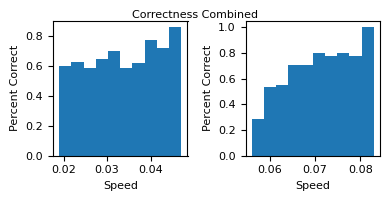

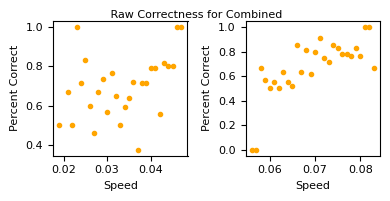

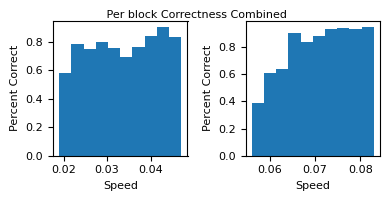

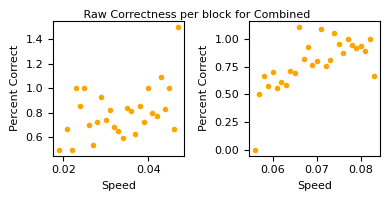

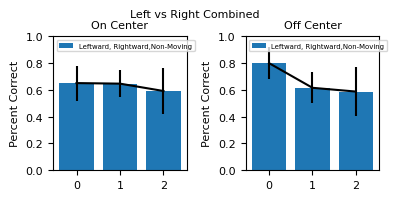

([0.6509433962264151, 0.6467889908256881, 0.5918367346938775],
 [0.8, 0.6157407407407407, 0.5876288659793815])

In [281]:

combined_subjects.plot_correctness_bar(show=True,savepath=CorrectPercentage_folder,n_bins=10)
combined_subjects.plot_correctness_raw(show=True, savepath=RawCorrect_folder)
combined_subjects.plot_correctness_block_bar(show=True, savepath=CorrectPercentage_folder,n_bins=10)
combined_subjects.plot_correctness_raw_block(show=True, savepath=RawCorrect_folder)
combined_subjects.left_vs_right(show=True, savepath=left_vs_right_folder,errors=left_right_errors)


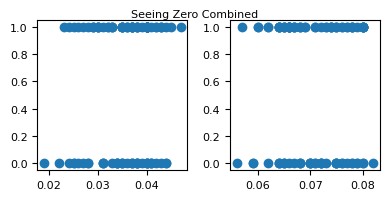

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000013FB209A9A0>,
      dtype=object)

In [282]:

combined_subjects.seeing_zero_scatter(show=True, savepath=ZeroSeeing_folder,ifhist=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18368\300124102.py:29: RuntimeWarning: invalid value encountered in divide
  subject_correctness/=subject_counts


Text(0.5, 0.98, 'Psychometric Curve for all subjects combined')

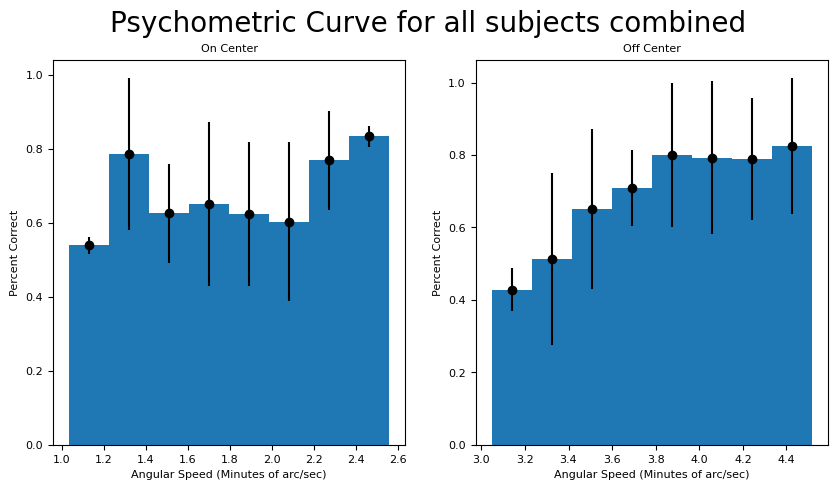

In [301]:
def plot_correctness_bar(sub_list,obj,axis,n_bins=5, on_center=True):
    min_speed,max_speed=obj.get_min_max_speed(obj.speedDict)
    bins = np.linspace(min_speed, max_speed, n_bins+1)
    bin_centers=(bins[1:]+bins[:-1])/2
    bin_width=bins[1]-bins[0]
    bin_correctness=np.zeros(n_bins)  
    counts=np.zeros(n_bins) 

    subject_correctness=np.zeros((len(subject_list),n_bins))
    subject_counts=np.zeros((len(subject_list),n_bins))
    
    
    for s,s_obj in obj.speedDict.items():
        if s==0:
            continue
        for i in range(len(bins)-1):
            if s>=bins[i] and s<bins[i+1]:
                bin_correctness[i]+=s_obj.get_percent_correct()*s_obj.n_valid
                counts[i]+=s_obj.n_valid
    for sub_index,sub in enumerate(sub_list):
        for s,s_obj in sub.speedDict.items():
            if s==0:
                continue
            #print(s,s_obj.n_valid)
            for i in range(len(bins)-1):
                if s>=bins[i] and s<bins[i+1]:
                    subject_correctness[sub_index,i]+=s_obj.get_percent_correct()*s_obj.n_valid
                    subject_counts[sub_index,i]+=s_obj.n_valid
    subject_correctness/=subject_counts

    bin_correctness=bin_correctness/counts
    # we find the standard deviation of not nan values in bin_correctness and plot errobars with it
    errors=np.nanstd(subject_correctness,axis=0)
    if on_center:
        bin_centers*=PIXEL_SIZE[0]*FRAME_RATE/MONITOR_DISTANCE*180/np.pi*60
        bin_width*=PIXEL_SIZE[0]*FRAME_RATE/MONITOR_DISTANCE*180/np.pi*60
    else:
        bin_centers*=PIXEL_SIZE[0]*FRAME_RATE/MONITOR_DISTANCE*(1/(1+(cross_distance/MONITOR_DISTANCE)**2))*180/np.pi*60
        bin_width*=PIXEL_SIZE[0]*FRAME_RATE/MONITOR_DISTANCE*(1/(1+(cross_distance/MONITOR_DISTANCE)**2))*180/np.pi*60
    axis.bar(bin_centers,bin_correctness,bin_width)
    axis.errorbar(bin_centers,bin_correctness,errors,fmt='o',color='black')
    axis.set_xlabel("Angular Speed (Minutes of arc/sec)")
    axis.set_ylabel("Percent Correct")
    return subject_correctness

fig,ax=plt.subplots(1,2,figsize=(10,5))
plot_correctness_bar([s.on_center_test for s in subject_list],combined_subjects.on_center_test,ax[0],n_bins=8)
plot_correctness_bar([s.off_center_test for s in subject_list],combined_subjects.off_center_test,ax[1],n_bins=8)
ax[0].set_title("On Center")
ax[1].set_title("Off Center")
fig.suptitle("Psychometric Curve for all subjects combined",fontsize=20)